# Breast Cancer Vital Status Prediction

This notebook predicts patient vital status (survival) using genomic and clinical data.

**Workflow:**
1. Load and analyze data
2. Preprocess data
3. Feature selection
4. Model training with hyperparameter tuning
5. Evaluation and visualization

## 1. Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold, SelectKBest, f_classif
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report, confusion_matrix, accuracy_score,
    roc_curve, roc_auc_score, precision_recall_curve, average_precision_score,
    precision_score, recall_score, f1_score
    )
import warnings
warnings.filterwarnings('ignore')

# Set plot style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

print("✅ All libraries imported successfully!")

✅ All libraries imported successfully!


## 2. Load and Analyze Data

In [2]:
# Load dataset
df = pd.read_csv('data.csv')

print("="*80)
print("DATASET OVERVIEW")
print("="*80)
print(f"\nDataset shape: {df.shape}")
print(f"Total samples: {len(df):,}")
print(f"Total columns: {len(df.columns):,}")
print(f"\nFirst 5 columns: {df.columns[:5].tolist()}")
print(f"Last 5 columns: {df.columns[-5:].tolist()}")

DATASET OVERVIEW

Dataset shape: (705, 1937)
Total samples: 705
Total columns: 1,937

First 5 columns: ['rs_CLEC3A', 'rs_CPB1', 'rs_SCGB2A2', 'rs_SCGB1D2', 'rs_TFF1']
Last 5 columns: ['pp_p70S6K', 'pp_p70S6K.pT389', 'pp_p90RSK', 'pp_p90RSK.pT359.S363', 'vital.status']



VITAL STATUS ANALYSIS

Vital Status Distribution:
vital.status
0    611
1     94
Name: count, dtype: int64

Class Balance:
  Survived (0): 611 (86.7%)
  Deceased (1): 94 (13.3%)


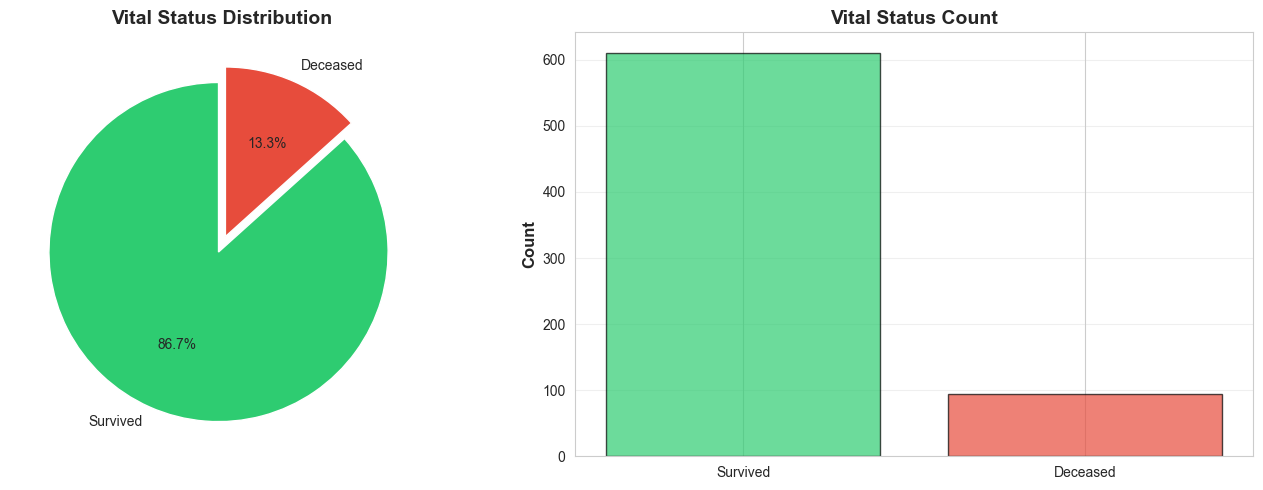

In [3]:
# Analyze vital status distribution
if 'vital.status' in df.columns:
    print("\n" + "="*80)
    print("VITAL STATUS ANALYSIS")
    print("="*80)
    print(f"\nVital Status Distribution:")
    print(df['vital.status'].value_counts())
    print(f"\nClass Balance:")
    print(f"  Survived (0): {(df['vital.status']==0).sum()} ({(df['vital.status']==0).sum()/len(df)*100:.1f}%)")
    print(f"  Deceased (1): {(df['vital.status']==1).sum()} ({(df['vital.status']==1).sum()/len(df)*100:.1f}%)")
    
    # Visualize
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Pie chart
    counts = df['vital.status'].value_counts()
    axes[0].pie(counts, labels=['Survived', 'Deceased'], autopct='%1.1f%%',
                colors=['#2ecc71', '#e74c3c'], startangle=90, explode=(0.05, 0.05))
    axes[0].set_title('Vital Status Distribution', fontsize=14, weight='bold')
    
    # Bar chart
    axes[1].bar(['Survived', 'Deceased'], counts.values, 
                color=['#2ecc71', '#e74c3c'], alpha=0.7, edgecolor='black')
    axes[1].set_ylabel('Count', fontsize=12, weight='bold')
    axes[1].set_title('Vital Status Count', fontsize=14, weight='bold')
    axes[1].grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.show()
else:
    print("⚠️ 'vital.status' column not found!")


FEATURE TYPE ANALYSIS

Gene expression (rs_*):    604 features
Protein expression (pp_*):  223 features
Copy number (cn_*):         860 features
Mutations (mu_*):           249 features

Total biological features:  1,936


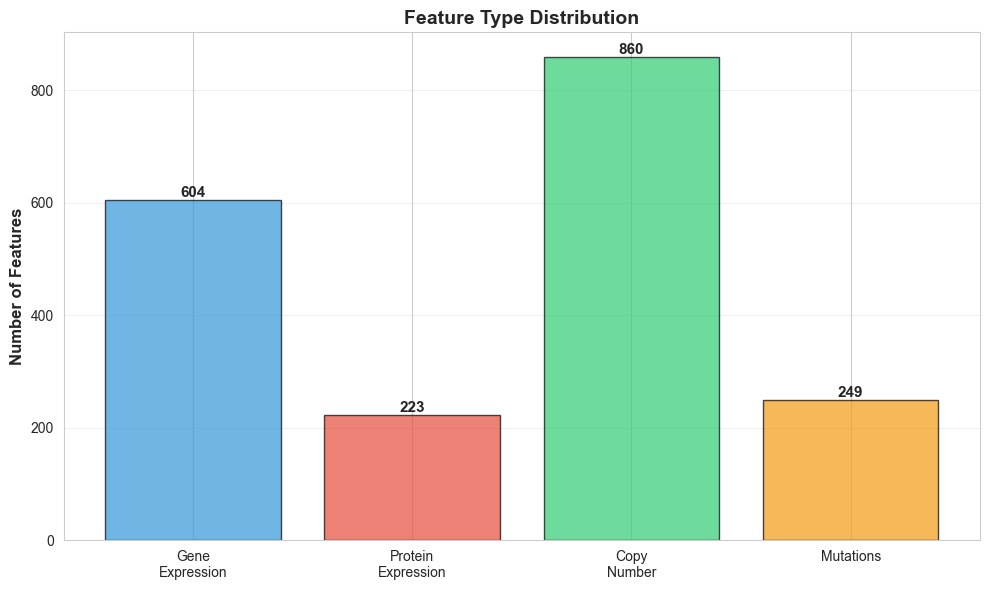

In [4]:
# Analyze feature types
gene_cols = [col for col in df.columns if col.startswith('rs_')]
protein_cols = [col for col in df.columns if col.startswith('pp_')]
cn_cols = [col for col in df.columns if col.startswith('cn_')]
mut_cols = [col for col in df.columns if col.startswith('mu_')]

print("\n" + "="*80)
print("FEATURE TYPE ANALYSIS")
print("="*80)
print(f"\nGene expression (rs_*):    {len(gene_cols):,} features")
print(f"Protein expression (pp_*):  {len(protein_cols):,} features")
print(f"Copy number (cn_*):         {len(cn_cols):,} features")
print(f"Mutations (mu_*):           {len(mut_cols):,} features")
print(f"\nTotal biological features:  {len(gene_cols + protein_cols + cn_cols + mut_cols):,}")

# Visualize feature distribution
feature_counts = {
    'Gene\nExpression': len(gene_cols),
    'Protein\nExpression': len(protein_cols),
    'Copy\nNumber': len(cn_cols),
    'Mutations': len(mut_cols)
}

plt.figure(figsize=(10, 6))
colors = ['#3498db', '#e74c3c', '#2ecc71', '#f39c12']
bars = plt.bar(feature_counts.keys(), feature_counts.values(), 
               color=colors, alpha=0.7, edgecolor='black')
plt.ylabel('Number of Features', fontsize=12, weight='bold')
plt.title('Feature Type Distribution', fontsize=14, weight='bold')
plt.grid(axis='y', alpha=0.3)

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{int(height):,}', ha='center', va='bottom', fontsize=11, weight='bold')

plt.tight_layout()
plt.show()

In [5]:
# Check missing values
missing_count = df.isnull().sum().sum()
missing_percent = (missing_count / (df.shape[0] * df.shape[1])) * 100

print("\n" + "="*80)
print("MISSING VALUES ANALYSIS")
print("="*80)
print(f"\nTotal missing values: {missing_count:,}")
print(f"Percentage missing: {missing_percent:.2f}%")

if missing_count > 0:
    cols_with_missing = df.isnull().sum()[df.isnull().sum() > 0].sort_values(ascending=False)
    print(f"\nColumns with missing values: {len(cols_with_missing)}")
    print(f"\nTop 10 columns with most missing values:")
    print(cols_with_missing.head(10))


MISSING VALUES ANALYSIS

Total missing values: 0
Percentage missing: 0.00%


## 3. Data Preprocessing

In [6]:
# Handle missing values
print("="*80)
print("PREPROCESSING: HANDLING MISSING VALUES")
print("="*80)
print(f"\nMissing values before: {df.isnull().sum().sum():,}")

df_clean = df.fillna(df.median(numeric_only=True))

print(f"Missing values after:  {df_clean.isnull().sum().sum():,}")
print("\n✅ Missing values imputed with median!")

PREPROCESSING: HANDLING MISSING VALUES

Missing values before: 0
Missing values after:  0

✅ Missing values imputed with median!
Missing values after:  0

✅ Missing values imputed with median!


In [7]:
# Prepare features and target
print("\n" + "="*80)
print("PREPARING FEATURES AND TARGET")
print("="*80)

feature_cols = gene_cols + protein_cols + cn_cols + mut_cols
X = df_clean[feature_cols]
y = df_clean['vital.status']

print(f"\nFeature matrix (X): {X.shape}")
print(f"Target vector (y):  {y.shape}")
print(f"\nTarget distribution:\n{y.value_counts()}")


PREPARING FEATURES AND TARGET

Feature matrix (X): (705, 1936)
Target vector (y):  (705,)

Target distribution:
vital.status
0    611
1     94
Name: count, dtype: int64


In [8]:
# Train-test split
print("\n" + "="*80)
print("TRAIN-TEST SPLIT")
print("="*80)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=3, stratify=y
)

print(f"\nTraining set: {X_train.shape[0]} samples ({X_train.shape[0]/len(X)*100:.0f}%)")
print(f"Test set:     {X_test.shape[0]} samples ({X_test.shape[0]/len(X)*100:.0f}%)")
print(f"\nTraining distribution:\n{y_train.value_counts()}")
print(f"\nTest distribution:\n{y_test.value_counts()}")


TRAIN-TEST SPLIT

Training set: 564 samples (80%)
Test set:     141 samples (20%)

Training distribution:
vital.status
0    489
1     75
Name: count, dtype: int64

Test distribution:
vital.status
0    122
1     19
Name: count, dtype: int64


In [9]:
# Feature scaling
print("\n" + "="*80)
print("FEATURE SCALING (STANDARDIZATION)")
print("="*80)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"\nScaled training data: {X_train_scaled.shape}")
print(f"Scaled test data:     {X_test_scaled.shape}")
print(f"\nMean of scaled features: {X_train_scaled.mean():.6f}")
print(f"Std of scaled features:  {X_train_scaled.std():.6f}")
print("\n✅ Features standardized (mean=0, std=1)!")


FEATURE SCALING (STANDARDIZATION)

Scaled training data: (564, 1936)
Scaled test data:     (141, 1936)

Mean of scaled features: 0.000000
Std of scaled features:  1.000000

✅ Features standardized (mean=0, std=1)!

Scaled training data: (564, 1936)
Scaled test data:     (141, 1936)

Mean of scaled features: 0.000000
Std of scaled features:  1.000000

✅ Features standardized (mean=0, std=1)!


## 4. Feature Selection

In [10]:
# Step 1: Remove low variance features
print("="*80)
print("FEATURE SELECTION: VARIANCE THRESHOLD")
print("="*80)
print(f"\nOriginal features: {X_train_scaled.shape[1]:,}")

selector_var = VarianceThreshold(threshold=0.01)
X_train_var = selector_var.fit_transform(X_train_scaled)
X_test_var = selector_var.transform(X_test_scaled)

removed_var = X_train_scaled.shape[1] - X_train_var.shape[1]
print(f"After variance filter: {X_train_var.shape[1]:,} features")
print(f"Removed: {removed_var:,} low-variance features")

FEATURE SELECTION: VARIANCE THRESHOLD

Original features: 1,936
After variance filter: 1,936 features
Removed: 0 low-variance features



FEATURE SELECTION: PREPARING FOR OPTIMIZATION

Maximum features available: 1,936
Feature selection will be optimized during hyperparameter tuning.
Testing different k values: [10, 20, 50, 100, 200, 300, 500]



FEATURE SELECTION: PREPARING FOR OPTIMIZATION

Maximum features available: 1,936
Feature selection will be optimized during hyperparameter tuning.
Testing different k values: [10, 20, 50, 100, 200, 300, 500]


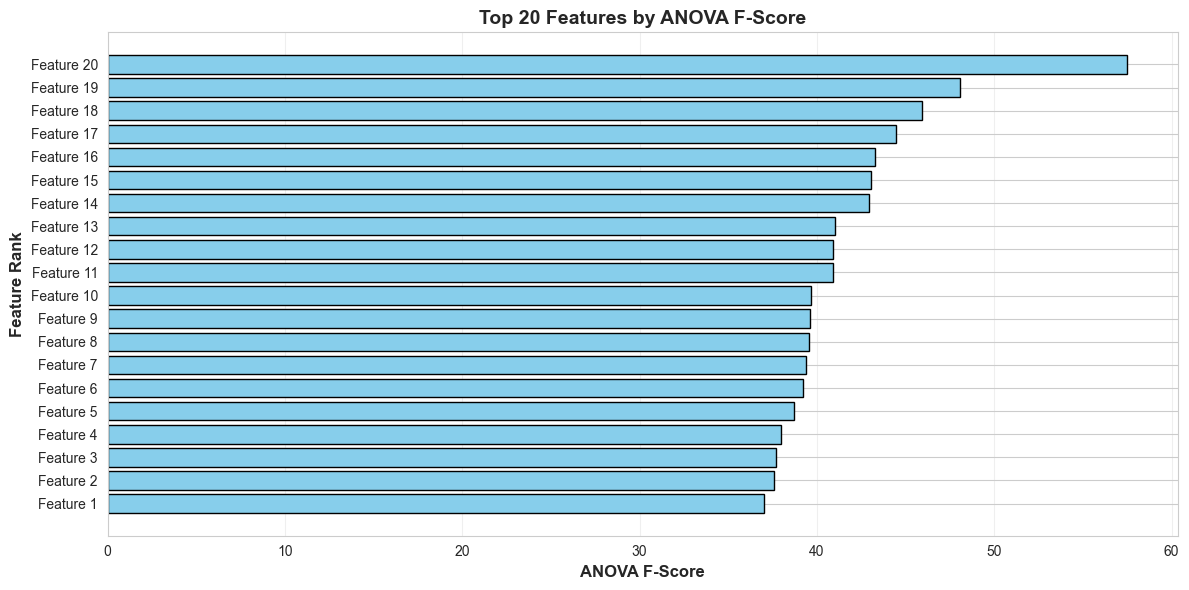


✅ Feature analysis complete! Optimal k will be found during tuning.


In [11]:
# Step 2: Prepare for feature selection (will be optimized in hyperparameter tuning)
print("\n" + "="*80)
print("FEATURE SELECTION: PREPARING FOR OPTIMIZATION")
print("="*80)

# We'll test different numbers of features in hyperparameter tuning
# For now, calculate F-scores for visualization
selector_temp = SelectKBest(score_func=f_classif, k='all')
selector_temp.fit(X_train_var, y_train)
feature_scores = selector_temp.scores_

max_features = X_train_var.shape[1]
print(f"\nMaximum features available: {max_features:,}")
print(f"Feature selection will be optimized during hyperparameter tuning.")
print(f"Testing different k values: [10, 20, 50, 100, 200, 300, 500]")

# Visualize top 20 features by F-score
top_20_idx = np.argsort(feature_scores)[-20:]
top_20_scores = feature_scores[top_20_idx]

plt.figure(figsize=(12, 6))
plt.barh(range(20), top_20_scores, color='skyblue', edgecolor='black')
plt.xlabel('ANOVA F-Score', fontsize=12, weight='bold')
plt.ylabel('Feature Rank', fontsize=12, weight='bold')
plt.title('Top 20 Features by ANOVA F-Score', fontsize=14, weight='bold')
plt.yticks(range(20), [f"Feature {i+1}" for i in range(20)])
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

print("\n✅ Feature analysis complete! Optimal k will be found during tuning.")

## 5. Hyperparameter Tuning with Feature Selection Optimization

We'll use Random Forest and optimize both the model hyperparameters and the number of features simultaneously.

In [12]:
# Random Forest Hyperparameter Tuning with Feature Selection
from sklearn.pipeline import Pipeline
import time

print("="*80)
print("RANDOM FOREST HYPERPARAMETER TUNING WITH FEATURE SELECTION")
print("="*80)

# Create pipeline with feature selection and Random Forest
pipeline = Pipeline([
    ('feature_selection', SelectKBest(score_func=f_classif)),
    ('classifier', RandomForestClassifier(random_state=3, n_jobs=-1))
])

# Define comprehensive hyperparameter grid with stronger regularization options
param_distributions = {
    'feature_selection__k': [5, 10, 20, 50, 100, 150, 200, 300, 500],
    'classifier__n_estimators': [200, 300, 500, 700, 900],
    'classifier__max_depth': [10, 15, 20, 25, 30, None],
    'classifier__min_samples_split': [2, 4, 6, 8, 12, 16, 24],
    'classifier__min_samples_leaf': [1, 2, 3, 4, 6, 8, 12],
    'classifier__max_features': ['sqrt', 'log2', 0.2, 0.3, 0.4, 0.5],
    'classifier__class_weight': [None, 'balanced', 'balanced_subsample', {0: 1, 1: 2}, {0: 1, 1: 3}],
    'classifier__bootstrap': [True, False],
    'classifier__ccp_alpha': [0.0, 0.0005, 0.001, 0.005]
}

print("\nSearching through hyperparameter space (including feature selection):")
for param, values in param_distributions.items():
    print(f"  • {param}: {values}")

cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=3)

# RandomizedSearchCV with cross-validation
random_search = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=param_distributions,
    n_iter=75,  # Number of different combinations to try
    cv=cv_strategy,
    scoring='roc_auc',  # Optimize for ROC-AUC
    verbose=2,
    random_state=3,
    n_jobs=-1,
    return_train_score=True
)

print(f"\n🔍 Running RandomizedSearchCV with 75 iterations and stratified 5-fold CV...")
print("Optimizing BOTH feature selection AND model hyperparameters, with class-weight tuning...")
print("Testing k values: [5, 10, 20, 50, 100, 150, 200, 300, 500]")
print("Scoring metric: ROC-AUC")
print("This may take several minutes...\n")

start_time = time.time()
random_search.fit(X_train_var, y_train)
training_time = time.time() - start_time

print("\n" + "="*80)
print("BEST HYPERPARAMETERS FOUND")
print("="*80)
print(f"\nBest CV ROC-AUC: {random_search.best_score_:.4f}")
print(f"Training time: {training_time:.2f} seconds")
print(f"\nBest Parameters:")
for param, value in random_search.best_params_.items():
    print(f"  • {param}: {value}")

# Extract the optimal number of features
optimal_k = random_search.best_params_.get('feature_selection__k', 500)
print(f"\n🎯 Optimal number of features: {optimal_k}")

tuned_model = random_search.best_estimator_
best_model_name = 'Random Forest'

print("\n✅ Hyperparameter tuning complete!")

RANDOM FOREST HYPERPARAMETER TUNING WITH FEATURE SELECTION

Searching through hyperparameter space (including feature selection):
  • feature_selection__k: [5, 10, 20, 50, 100, 150, 200, 300, 500]
  • classifier__n_estimators: [200, 300, 500, 700, 900]
  • classifier__max_depth: [10, 15, 20, 25, 30, None]
  • classifier__min_samples_split: [2, 4, 6, 8, 12, 16, 24]
  • classifier__min_samples_leaf: [1, 2, 3, 4, 6, 8, 12]
  • classifier__max_features: ['sqrt', 'log2', 0.2, 0.3, 0.4, 0.5]
  • classifier__class_weight: [None, 'balanced', 'balanced_subsample', {0: 1, 1: 2}, {0: 1, 1: 3}]
  • classifier__bootstrap: [True, False]
  • classifier__ccp_alpha: [0.0, 0.0005, 0.001, 0.005]

🔍 Running RandomizedSearchCV with 75 iterations and stratified 5-fold CV...
Optimizing BOTH feature selection AND model hyperparameters, with class-weight tuning...
Testing k values: [5, 10, 20, 50, 100, 150, 200, 300, 500]
Scoring metric: ROC-AUC
This may take several minutes...

Fitting 5 folds for each of 75 

### What the Expanded Hyperparameter Grid Covers
- `feature_selection__k`: Tests how many top-scoring features (after the variance filter) the model should keep; lower values reduce noise, higher values capture more signal.
- `classifier__n_estimators`: Number of trees; more trees reduce variance at the cost of training time.
- `classifier__max_depth`: Caps tree depth to combat overfitting; `None` lets trees grow fully.
- `classifier__min_samples_split`: Minimum samples needed to split an internal node; higher values enforce more conservative splits.
- `classifier__min_samples_leaf`: Minimum samples in a leaf node; helps regularize tiny leaves that can inflate accuracy but hurt ROC-AUC.
- `classifier__max_features`: Feature subset size per split; floats represent proportions of the feature set for each split.
- `classifier__class_weight`: Balances the minority (deceased) class via built-in heuristics or custom ratios to improve recall without synthetic sampling.
- `classifier__bootstrap`: Toggles bootstrap sampling; disabling it can sometimes sharpen ROC-AUC when combined with higher `ccp_alpha`.
- `classifier__ccp_alpha`: Applies minimal cost-complexity pruning to every tree, trimming branches that add little value and improving generalization of probabilities.

## 6. Hyperparameter Tuning Results Visualization

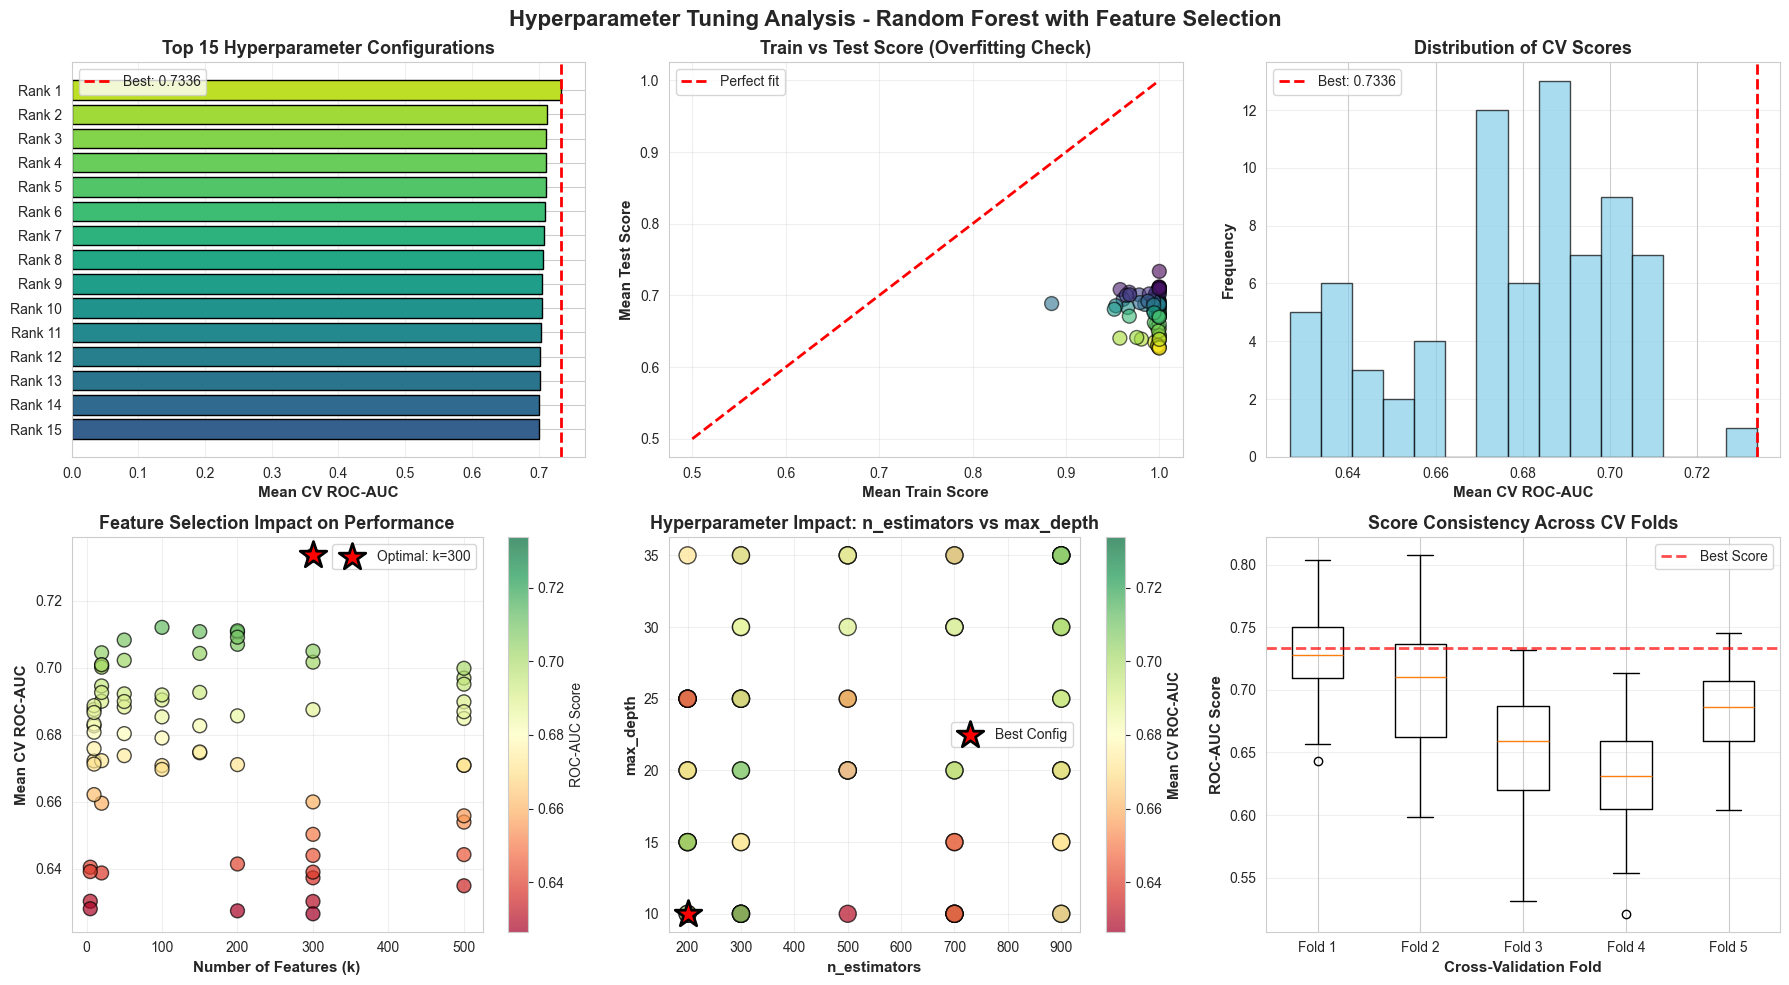


TUNING SUMMARY
Total configurations tested: 75
Best CV ROC-AUC: 0.7336
Mean CV ROC-AUC: 0.6776
Std CV ROC-AUC: 0.0253

Optimal configuration:
  • Number of features: 300
  • n_estimators: 200
  • max_depth: 10
  • Best score: 0.7336


In [13]:
# Visualize hyperparameter tuning results
results_df = pd.DataFrame(random_search.cv_results_)

fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# Plot 1: Top 15 configurations
ax1 = axes[0, 0]
top_15 = results_df.nsmallest(15, 'rank_test_score')[['rank_test_score', 'mean_test_score']].sort_values('mean_test_score')
colors_plot = plt.cm.viridis(np.linspace(0.3, 0.9, len(top_15)))
ax1.barh(range(len(top_15)), top_15['mean_test_score'], color=colors_plot, edgecolor='black')
ax1.set_yticks(range(len(top_15)))
ax1.set_yticklabels([f"Rank {int(r)}" for r in top_15['rank_test_score']])
ax1.set_xlabel('Mean CV ROC-AUC', fontsize=11, weight='bold')
ax1.set_title('Top 15 Hyperparameter Configurations', fontsize=13, weight='bold')
ax1.axvline(random_search.best_score_, color='red', linestyle='--', linewidth=2, label=f'Best: {random_search.best_score_:.4f}')
ax1.legend()
ax1.grid(axis='x', alpha=0.3)

# Plot 2: Train vs Test scores (overfitting check)
ax2 = axes[0, 1]
ax2.scatter(results_df['mean_train_score'], results_df['mean_test_score'],
           alpha=0.6, s=100, c=results_df['rank_test_score'], cmap='viridis', edgecolors='black')
ax2.plot([0.5, 1.0], [0.5, 1.0], 'r--', lw=2, label='Perfect fit')
ax2.set_xlabel('Mean Train Score', fontsize=11, weight='bold')
ax2.set_ylabel('Mean Test Score', fontsize=11, weight='bold')
ax2.set_title('Train vs Test Score (Overfitting Check)', fontsize=13, weight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Plot 3: Score distribution
ax3 = axes[0, 2]
ax3.hist(results_df['mean_test_score'], bins=15, color='skyblue', edgecolor='black', alpha=0.7)
ax3.axvline(random_search.best_score_, color='red', linestyle='--', linewidth=2, label=f'Best: {random_search.best_score_:.4f}')
ax3.set_xlabel('Mean CV ROC-AUC', fontsize=11, weight='bold')
ax3.set_ylabel('Frequency', fontsize=11, weight='bold')
ax3.set_title('Distribution of CV Scores', fontsize=13, weight='bold')
ax3.legend()
ax3.grid(axis='y', alpha=0.3)

# Plot 4: Feature Selection Impact
ax4 = axes[1, 0]
k_values = results_df['param_feature_selection__k'].values
scores = results_df['mean_test_score'].values
scatter = ax4.scatter(k_values, scores, c=scores, s=100, cmap='RdYlGn', edgecolors='black', alpha=0.7)
ax4.set_xlabel('Number of Features (k)', fontsize=11, weight='bold')
ax4.set_ylabel('Mean CV ROC-AUC', fontsize=11, weight='bold')
ax4.set_title('Feature Selection Impact on Performance', fontsize=13, weight='bold')
ax4.grid(True, alpha=0.3)
plt.colorbar(scatter, ax=ax4, label='ROC-AUC Score')

# Mark optimal k
optimal_k_score = random_search.best_score_
ax4.scatter([optimal_k], [optimal_k_score], s=400, c='red', marker='*',
           edgecolors='black', linewidths=2, label=f'Optimal: k={optimal_k}', zorder=5)
ax4.legend()

# Plot 5: n_estimators vs max_depth impact
ax5 = axes[1, 1]
scatter2 = ax5.scatter(
    results_df['param_classifier__n_estimators'].astype(float),
    results_df['param_classifier__max_depth'].fillna(35).astype(float),
    c=results_df['mean_test_score'],
    s=150,
    cmap='RdYlGn',
    edgecolors='black',
    alpha=0.7
)
ax5.set_xlabel('n_estimators', fontsize=11, weight='bold')
ax5.set_ylabel('max_depth', fontsize=11, weight='bold')
ax5.set_title('Hyperparameter Impact: n_estimators vs max_depth', fontsize=13, weight='bold')
ax5.grid(True, alpha=0.3)
cbar = plt.colorbar(scatter2, ax=ax5)
cbar.set_label('Mean CV ROC-AUC', fontsize=10, weight='bold')

# Mark best configuration
best_n_est = random_search.best_params_.get('classifier__n_estimators', 200)
best_max_depth = random_search.best_params_.get('classifier__max_depth', 10)
best_max_depth = best_max_depth if best_max_depth is not None else 35
ax5.scatter(best_n_est, best_max_depth, s=400, c='red', marker='*',
           edgecolors='black', linewidths=2, label='Best Config', zorder=5)
ax5.legend()

# Plot 6: Cross-validation fold consistency
ax6 = axes[1, 2]
fold_scores = []
for i in range(5):
    fold_scores.append(results_df[f'split{i}_test_score'].values)
ax6.boxplot(fold_scores, labels=[f'Fold {i+1}' for i in range(5)])
ax6.set_ylabel('ROC-AUC Score', fontsize=11, weight='bold')
ax6.set_xlabel('Cross-Validation Fold', fontsize=11, weight='bold')
ax6.set_title('Score Consistency Across CV Folds', fontsize=13, weight='bold')
ax6.grid(axis='y', alpha=0.3)
ax6.axhline(random_search.best_score_, color='red', linestyle='--', linewidth=2, label='Best Score', alpha=0.7)
ax6.legend()

plt.suptitle('Hyperparameter Tuning Analysis - Random Forest with Feature Selection', fontsize=16, weight='bold')
plt.tight_layout()
plt.show()

# Print summary
print("\n" + "="*80)
print("TUNING SUMMARY")
print("="*80)
print(f"Total configurations tested: {len(results_df)}")
print(f"Best CV ROC-AUC: {results_df['mean_test_score'].max():.4f}")
print(f"Mean CV ROC-AUC: {results_df['mean_test_score'].mean():.4f}")
print(f"Std CV ROC-AUC: {results_df['mean_test_score'].std():.4f}")
print(f"\nOptimal configuration:")
print(f"  • Number of features: {optimal_k}")
print(f"  • n_estimators: {random_search.best_params_['classifier__n_estimators']}")
print(f"  • max_depth: {random_search.best_params_['classifier__max_depth']}")
print(f"  • Best score: {random_search.best_score_:.4f}")


## 7. Final Model Evaluation

In [14]:
# Use the tuned model for final predictions
final_model = tuned_model

y_pred_proba = final_model.predict_proba(X_test_var)[:, 1]

# Baseline metrics at the default threshold (0.50)
y_pred_default = (y_pred_proba >= 0.50).astype(int)
baseline_accuracy = accuracy_score(y_test, y_pred_default)
baseline_precision = precision_score(y_test, y_pred_default, average='weighted', zero_division=0)
baseline_recall = recall_score(y_test, y_pred_default, average='weighted', zero_division=0)
baseline_f1 = f1_score(y_test, y_pred_default, average='weighted', zero_division=0)
baseline_report = classification_report(y_test, y_pred_default, target_names=['Survived', 'Deceased'])
baseline_confusion = confusion_matrix(y_test, y_pred_default)
tn_b, fp_b, fn_b, tp_b = baseline_confusion.ravel()
baseline_sensitivity = tp_b / (tp_b + fn_b) if (tp_b + fn_b) > 0 else 0.0
baseline_specificity = tn_b / (tn_b + fp_b) if (tn_b + fp_b) > 0 else 0.0

# Identify optimal threshold using Youden's J statistic
fpr_vals, tpr_vals, thresholds = roc_curve(y_test, y_pred_proba)
j_scores = tpr_vals - fpr_vals
best_idx = np.argmax(j_scores)
best_threshold = thresholds[best_idx]
y_pred_optimal = (y_pred_proba >= best_threshold).astype(int)

optimized_confusion = confusion_matrix(y_test, y_pred_optimal)
tn_o, fp_o, fn_o, tp_o = optimized_confusion.ravel()
best_sensitivity = tp_o / (tp_o + fn_o) if (tp_o + fn_o) > 0 else 0.0
best_specificity = tn_o / (tn_o + fp_o) if (tn_o + fp_o) > 0 else 0.0

accuracy = accuracy_score(y_test, y_pred_optimal)
roc_auc = roc_auc_score(y_test, y_pred_proba)
precision_opt = precision_score(y_test, y_pred_optimal, average='weighted', zero_division=0)
recall_opt = recall_score(y_test, y_pred_optimal, average='weighted', zero_division=0)
f1_opt = f1_score(y_test, y_pred_optimal, average='weighted', zero_division=0)
optimal_report = classification_report(y_test, y_pred_optimal, target_names=['Survived', 'Deceased'])

baseline_metrics = {
    'accuracy': baseline_accuracy,
    'precision': baseline_precision,
    'recall': baseline_recall,
    'f1': baseline_f1,
    'sensitivity': baseline_sensitivity,
    'specificity': baseline_specificity,
    'confusion': baseline_confusion
}

metrics_opt = {
    'accuracy': accuracy,
    'precision': precision_opt,
    'recall': recall_opt,
    'f1': f1_opt,
    'sensitivity': best_sensitivity,
    'specificity': best_specificity,
    'confusion': optimized_confusion
}

print("="*80)
print(f"FINAL MODEL PERFORMANCE: {best_model_name} (TUNED)")
print("="*80)
print(f"\nROC-AUC (probability-based): {roc_auc:.4f}")
print(f"Best threshold (Youden's J):  {best_threshold:.3f}")

print("\nBASELINE (threshold = 0.50)")
print(f"  Accuracy:   {baseline_accuracy:.4f}")
print(f"  Precision:  {baseline_precision:.4f}")
print(f"  Recall:     {baseline_recall:.4f}")
print(f"  F1-Score:   {baseline_f1:.4f}")
print(f"  Sensitivity:{baseline_sensitivity:.4f}")
print(f"  Specificity:{baseline_specificity:.4f}")
print(baseline_report)

print("OPTIMIZED (threshold = {:.3f})".format(best_threshold))
print(f"  Accuracy:   {accuracy:.4f}")
print(f"  Precision:  {precision_opt:.4f}")
print(f"  Recall:     {recall_opt:.4f}")
print(f"  F1-Score:   {f1_opt:.4f}")
print(f"  Sensitivity:{best_sensitivity:.4f}")
print(f"  Specificity:{best_specificity:.4f}")
print(optimal_report)

# Make optimized predictions available to downstream cells
y_pred = y_pred_optimal

FINAL MODEL PERFORMANCE: Random Forest (TUNED)

ROC-AUC (probability-based): 0.5220
Best threshold (Youden's J):  0.405

BASELINE (threshold = 0.50)
  Accuracy:   0.8794
  Precision:  0.8653
  Recall:     0.8794
  F1-Score:   0.8436
  Sensitivity:0.1579
  Specificity:0.9918
              precision    recall  f1-score   support

    Survived       0.88      0.99      0.93       122
    Deceased       0.75      0.16      0.26        19

    accuracy                           0.88       141
   macro avg       0.82      0.57      0.60       141
weighted avg       0.87      0.88      0.84       141

OPTIMIZED (threshold = 0.405)
  Accuracy:   0.8794
  Precision:  0.8584
  Recall:     0.8794
  F1-Score:   0.8575
  Sensitivity:0.2632
  Specificity:0.9754
              precision    recall  f1-score   support

    Survived       0.89      0.98      0.93       122
    Deceased       0.62      0.26      0.37        19

    accuracy                           0.88       141
   macro avg       0.76 

### Threshold Impact Analysis
The table below compares the default 0.50 decision threshold with the optimized threshold derived from Youden's J statistic, highlighting how sensitivity/specificity and aggregate metrics change.

In [15]:
optimized_label = f"Threshold {best_threshold:.3f} (Youden)"
comparison_df = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'Sensitivity', 'Specificity'],
    'Threshold 0.50': [
        baseline_metrics['accuracy'],
        baseline_metrics['precision'],
        baseline_metrics['recall'],
        baseline_metrics['f1'],
        baseline_metrics['sensitivity'],
        baseline_metrics['specificity']
    ],
    optimized_label: [
        metrics_opt['accuracy'],
        metrics_opt['precision'],
        metrics_opt['recall'],
        metrics_opt['f1'],
        metrics_opt['sensitivity'],
        metrics_opt['specificity']
    ]
})
comparison_df['Delta (opt - default)'] = comparison_df[optimized_label] - comparison_df['Threshold 0.50']
display(comparison_df.round(4))

print("Baseline confusion matrix (threshold 0.50):")
print(baseline_metrics['confusion'])
print("\nOptimized confusion matrix (threshold {:.3f}):".format(best_threshold))
print(metrics_opt['confusion'])

,Metric,Threshold 0.50,Threshold 0.405 (Youden),Delta (opt - default)
0,Accuracy,0.8794,0.8794,0.0000
1,Precision,0.8653,0.8584,-0.0069
2,Recall,0.8794,0.8794,0.0000
3,F1-Score,0.8436,0.8575,0.0139
4,Sensitivity,0.1579,0.2632,0.1053
5,Specificity,0.9918,0.9754,-0.0164


Baseline confusion matrix (threshold 0.50):
[[121   1]
 [ 16   3]]

Optimized confusion matrix (threshold 0.405):
[[119   3]
 [ 14   5]]


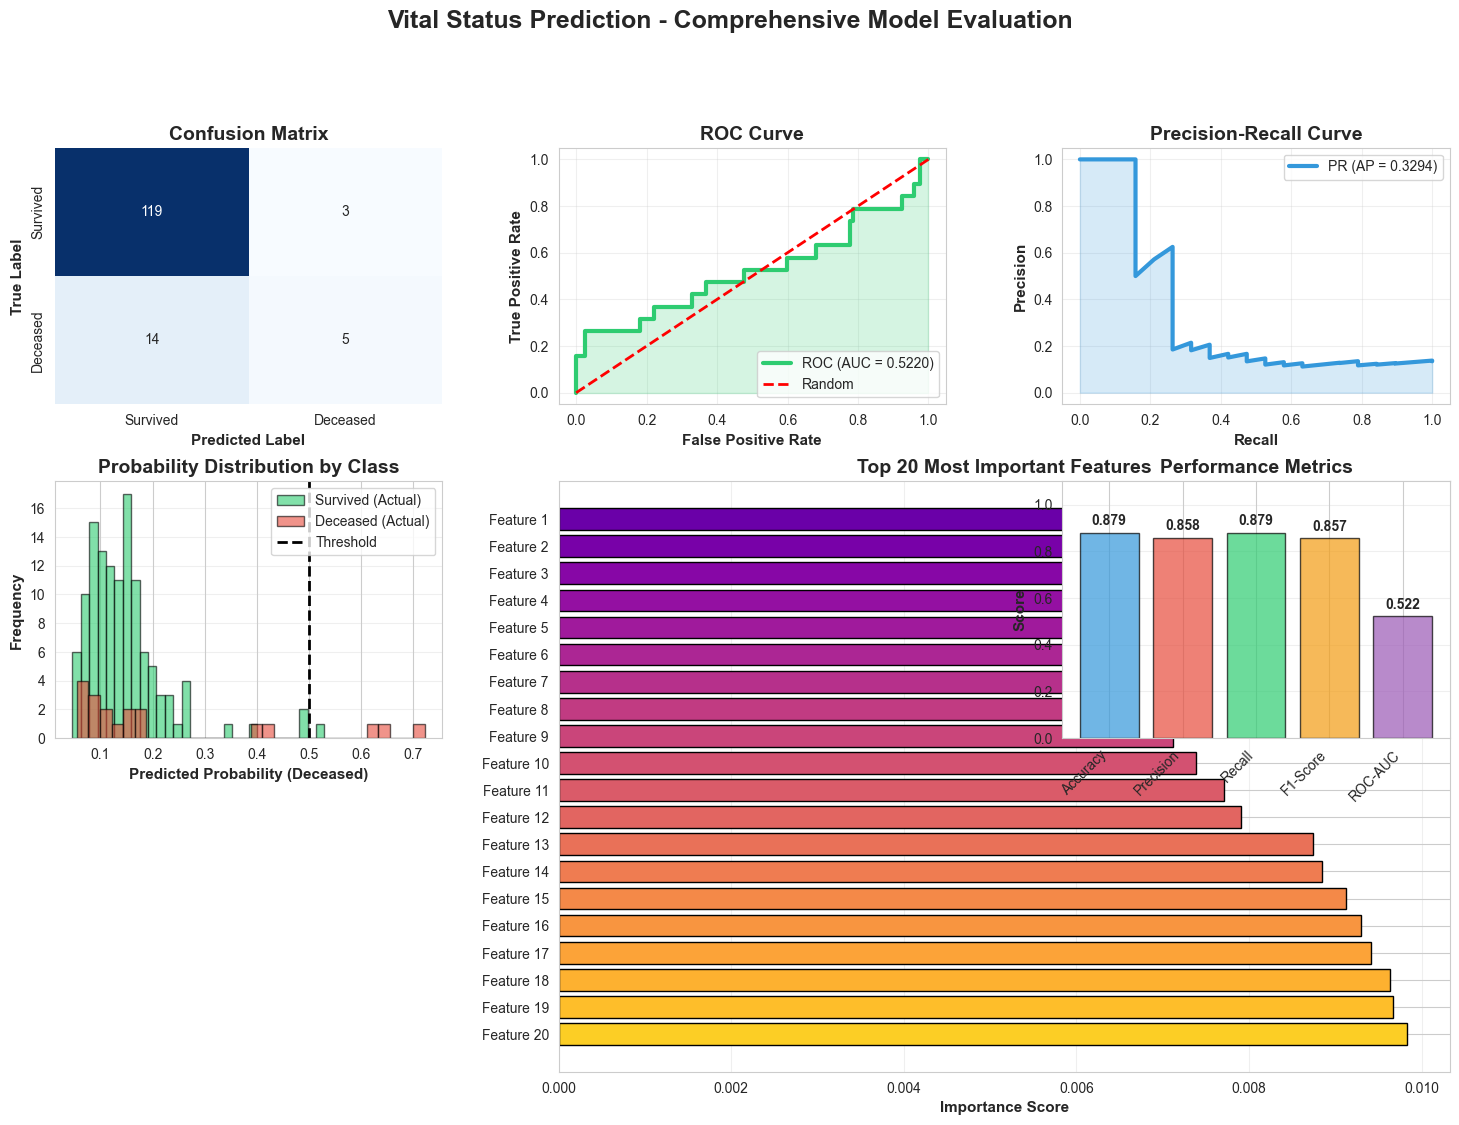


✅ Model evaluation complete!


In [16]:
# Comprehensive visualization dashboard
fig = plt.figure(figsize=(18, 12))
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

# 1. Confusion Matrix
ax1 = fig.add_subplot(gs[0, 0])
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax1, cbar=False)
ax1.set_title('Confusion Matrix', fontsize=14, weight='bold')
ax1.set_ylabel('True Label', fontsize=11, weight='bold')
ax1.set_xlabel('Predicted Label', fontsize=11, weight='bold')
ax1.set_xticklabels(['Survived', 'Deceased'])
ax1.set_yticklabels(['Survived', 'Deceased'])

# 2. ROC Curve
ax2 = fig.add_subplot(gs[0, 1])
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
ax2.plot(fpr, tpr, color='#2ecc71', lw=3, label=f'ROC (AUC = {roc_auc:.4f})')
ax2.plot([0, 1], [0, 1], 'r--', lw=2, label='Random')
ax2.fill_between(fpr, tpr, alpha=0.2, color='#2ecc71')
ax2.set_xlabel('False Positive Rate', fontsize=11, weight='bold')
ax2.set_ylabel('True Positive Rate', fontsize=11, weight='bold')
ax2.set_title('ROC Curve', fontsize=14, weight='bold')
ax2.legend(loc='lower right')
ax2.grid(alpha=0.3)

# 3. Precision-Recall Curve
ax3 = fig.add_subplot(gs[0, 2])
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
ap_score = average_precision_score(y_test, y_pred_proba)
ax3.plot(recall, precision, color='#3498db', lw=3, label=f'PR (AP = {ap_score:.4f})')
ax3.fill_between(recall, precision, alpha=0.2, color='#3498db')
ax3.set_xlabel('Recall', fontsize=11, weight='bold')
ax3.set_ylabel('Precision', fontsize=11, weight='bold')
ax3.set_title('Precision-Recall Curve', fontsize=14, weight='bold')
ax3.legend(loc='best')
ax3.grid(alpha=0.3)

# 4. Predicted Probability Distribution
ax4 = fig.add_subplot(gs[1, 0])
y_test_array = np.array(y_test)
proba_survived = y_pred_proba[y_test_array == 0]
proba_deceased = y_pred_proba[y_test_array == 1]
ax4.hist(proba_survived, bins=30, alpha=0.6, label='Survived (Actual)', color='#2ecc71', edgecolor='black')
ax4.hist(proba_deceased, bins=30, alpha=0.6, label='Deceased (Actual)', color='#e74c3c', edgecolor='black')
ax4.axvline(0.5, color='black', linestyle='--', linewidth=2, label='Threshold')
ax4.set_xlabel('Predicted Probability (Deceased)', fontsize=11, weight='bold')
ax4.set_ylabel('Frequency', fontsize=11, weight='bold')
ax4.set_title('Probability Distribution by Class', fontsize=14, weight='bold')
ax4.legend()
ax4.grid(axis='y', alpha=0.3)

# 5. Feature Importance
ax5 = fig.add_subplot(gs[1:, 1:])
# Extract feature importance from the pipeline
if hasattr(final_model, 'named_steps'):
    classifier = final_model.named_steps['classifier']
else:
    classifier = final_model

if hasattr(classifier, 'feature_importances_'):
    feature_importance = classifier.feature_importances_
    top_20_indices = np.argsort(feature_importance)[-20:]
    top_20_importance = feature_importance[top_20_indices]
else:
    feature_importance = np.zeros(20)
    top_20_indices = np.arange(20)
    top_20_importance = feature_importance
colors_feat = plt.cm.plasma(np.linspace(0.2, 0.9, 20))
ax5.barh(range(20), top_20_importance, color=colors_feat, edgecolor='black')
ax5.set_yticks(range(20))
ax5.set_yticklabels([f"Feature {i+1}" for i in range(20)])
ax5.set_xlabel('Importance Score', fontsize=11, weight='bold')
ax5.set_title('Top 20 Most Important Features', fontsize=14, weight='bold')
ax5.invert_yaxis()
ax5.grid(axis='x', alpha=0.3)

# 6. Performance Metrics Bar
ax6 = fig.add_subplot(gs[1, 2])
from sklearn.metrics import precision_score, recall_score, f1_score
metrics = {
    'Accuracy': accuracy,
    'Precision': precision_score(y_test, y_pred, average='weighted'),
    'Recall': recall_score(y_test, y_pred, average='weighted'),
    'F1-Score': f1_score(y_test, y_pred, average='weighted'),
    'ROC-AUC': roc_auc
}
bars = ax6.bar(metrics.keys(), metrics.values(), 
               color=['#3498db', '#e74c3c', '#2ecc71', '#f39c12', '#9b59b6'],
               alpha=0.7, edgecolor='black')
ax6.set_ylabel('Score', fontsize=11, weight='bold')
ax6.set_title('Performance Metrics', fontsize=14, weight='bold')
ax6.set_ylim([0, 1.1])
ax6.grid(axis='y', alpha=0.3)
plt.setp(ax6.xaxis.get_majorticklabels(), rotation=45, ha='right')
for bar, val in zip(bars, metrics.values()):
    ax6.text(bar.get_x() + bar.get_width()/2, val + 0.02, f'{val:.3f}',
            ha='center', va='bottom', fontsize=10, weight='bold')

plt.suptitle('Vital Status Prediction - Comprehensive Model Evaluation', 
             fontsize=18, weight='bold', y=0.995)
plt.show()

print("\n✅ Model evaluation complete!") 


## 7. Final Summary

In [17]:
print("\n" + "="*80)
print("FINAL MODEL SUMMARY")
print("="*80)

print("\n📊 DATASET:")
print(f"  • Total samples: {len(df):,}")
print(f"  • Features (original): {len(feature_cols):,}")
optimal_k = random_search.best_params_.get('feature_selection__k', 'N/A')
print(f"  • Features (selected): {optimal_k}")
if isinstance(optimal_k, int):
    print(f"  • Feature reduction: {(1-optimal_k/len(feature_cols))*100:.1f}%")

print("\n🔬 PREPROCESSING:")
print(f"  • Missing values imputed: Median")
print(f"  • Feature scaling: StandardScaler")
print(f"  • Variance threshold: 0.01")
optimal_k = random_search.best_params_.get('feature_selection__k', 'N/A')
print(f"  • Top K features: {optimal_k} (optimized via hyperparameter tuning)")

print("\n🤖 MODEL:")
print(f"  • Algorithm: {best_model_name}")
print(f"  • Hyperparameter tuning: RandomizedSearchCV (75 iterations, stratified 5-fold CV, ROC-AUC scoring)")
print(f"  • CV Score: {random_search.best_score_:.4f}")
print(f"  • Best parameters:")
for param, value in random_search.best_params_.items():
    print(f"      - {param}: {value}")

print("\n📈 PERFORMANCE:")
print(f"  • Accuracy:  {accuracy:.4f}")
print(f"  • Precision: {precision_score(y_test, y_pred, average='weighted'):.4f}")
print(f"  • Recall:    {recall_score(y_test, y_pred, average='weighted'):.4f}")
print(f"  • F1-Score:  {f1_score(y_test, y_pred, average='weighted'):.4f}")
print(f"  • ROC-AUC:   {roc_auc:.4f}")
if 'best_threshold' in globals():
    print(f"  • Optimal threshold (Youden's J): {best_threshold:.3f}")
    print(f"  • Sensitivity at optimal threshold: {best_sensitivity:.3f}")
    print(f"  • Specificity at optimal threshold: {best_specificity:.3f}")

print("\n🎯 INTERPRETATION:")
if roc_auc > 0.9:
    print("  ✅ EXCELLENT model performance (AUC > 0.9)")
elif roc_auc > 0.8:
    print("  ✅ GOOD model performance (AUC > 0.8)")
elif roc_auc > 0.7:
    print("  ✅ ACCEPTABLE model performance (AUC > 0.7)")
else:
    print("  ⚠️ NEEDS IMPROVEMENT (AUC ≤ 0.7)")

print("\n" + "="*80)
print("🎉 ANALYSIS COMPLETE!")
print("="*80)


FINAL MODEL SUMMARY

📊 DATASET:
  • Total samples: 705
  • Features (original): 1,936
  • Features (selected): 300
  • Feature reduction: 84.5%

🔬 PREPROCESSING:
  • Missing values imputed: Median
  • Feature scaling: StandardScaler
  • Variance threshold: 0.01
  • Top K features: 300 (optimized via hyperparameter tuning)

🤖 MODEL:
  • Algorithm: Random Forest
  • Hyperparameter tuning: RandomizedSearchCV (75 iterations, stratified 5-fold CV, ROC-AUC scoring)
  • CV Score: 0.7336
  • Best parameters:
      - feature_selection__k: 300
      - classifier__n_estimators: 200
      - classifier__min_samples_split: 6
      - classifier__min_samples_leaf: 2
      - classifier__max_features: log2
      - classifier__max_depth: 10
      - classifier__class_weight: balanced_subsample
      - classifier__ccp_alpha: 0.0
      - classifier__bootstrap: True

📈 PERFORMANCE:
  • Accuracy:  0.8794
  • Precision: 0.8584
  • Recall:    0.8794
  • F1-Score:  0.8575
  • ROC-AUC:   0.5220
  • Optimal thres